# **Stance detection on COVID-19 vaccination tweets**

In [ ]:
import pandas as pd
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## **Data Preprocessing**

In [ ]:
read_csv_path = '/content/final.csv'
write_csv_path = '/content/final_cleaned.csv'

# read training dataset csv file
df=pd.read_csv(read_csv_path,encoding='utf-8',header=0)
print(df.head(10))
print(df.shape,df.columns)

nltk.download('stopwords')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# remove hashtags, numbers, urls etc.
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

def splitTweet(text):
    return text.split()

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(l):
    return [word for word in l if len(word) > 2 and word not in STOPWORDS]

def lemmatization(l):
    temp = []
    for i in l:
        temp.append((wordnet_lemmatizer.lemmatize(i)).lower())
    return " ".join(temp)

# clean the tweet
df['Tweet'] = df['text'].apply(cleanText)

# split each tweet by space and make list
df['Split_tweet'] = df['Tweet'].apply(splitTweet)

# remove stopwords
df['Clean_tweet'] = df['Split_tweet'].apply(remove_stopwords)

# lemmatize tweet
df['Lemmatized_tweet'] = df['Clean_tweet'].apply(lemmatization)

# remove empty tweets row
df = df[df['Lemmatized_tweet'] != '']

# remove empty tweets
df = df.dropna()

# write clean text into another csv
df_new = pd.DataFrame({ 'Clean_text': df['Lemmatized_tweet'],'label':df['category']})
df_new.to_csv(write_csv_path, index=False)

   Unnamed: 0  ...  category
0           0  ...       2.0
1           1  ...       0.0
2           2  ...       0.0
3           3  ...       0.0
4           4  ...       2.0
5           5  ...       2.0
6           6  ...       2.0
7           7  ...       2.0
8           8  ...       0.0
9           9  ...       2.0

[10 rows x 4 columns]
(2770, 4) Index(['Unnamed: 0', 'id', 'text', 'category'], dtype='object')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_new.head()

,Clean_text,label
0,great job pfizer vaccine scientist look come v...,2.0
1,the coronavirus effective clue long term effec...,0.0
2,bother profs different section tell public sta...,0.0
3,they say vaccine tested animal take never leav...,0.0
4,care voted go proper scientific medical proced...,2.0


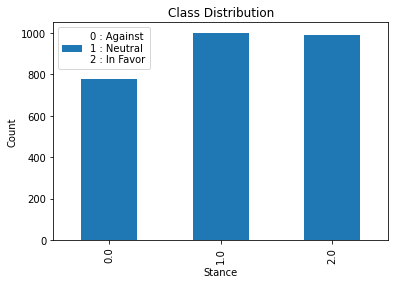

In [ ]:
# Class distribution in training dataset

import matplotlib.pyplot as plt
df_new['label'].value_counts().sort_index().plot.bar()
plt.xlabel("Stance")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.legend(["0 : Against\n1 : Neutral\n2 : In Favor"])
plt.show()

## **Feature Extraction**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
# create n-gram vector object 
vectorizer = CountVectorizer(ngram_range=(1, 2),max_features=1000)

In [ ]:
# apply n-gram vector object on clean tweets

X = vectorizer.fit_transform(df_new['Clean_text'])
feature_names = vectorizer.get_feature_names()

df_ngram = pd.DataFrame(data=X.toarray(),columns=feature_names)
y_train = df_new['label']

In [ ]:
df_ngram.head()

,able,absolutely,access,access covid,according,across,actually,administration,adult,adverse,after,age,ago,agree,ahead,all,almost,alone,already,also,alter,alter dna,always,amazing,amazing news,america,american,americans,among,amp,analysis,analysis show,and,animal,announce,announced,announcement,another,answer,anti,...,what,when,where,whether,which,while,who,why,will,willing,win,with,within,within day,without,without vaccine,woman,work,work http,worked,worker,working,world,worry,worse,worth,would,would get,would take,wow,wrong,yeah,year,year develop,year old,yes,yet,york,you,your
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split the dataset into training and testing parts

X_train,x_test,Y_train,y_test = train_test_split(df_ngram,y_train,train_size=.80)

In [ ]:
# normalizing (scaling)

x_max = X_train.max()
x_min = X_train.min()

X_train = (X_train - x_min)/x_max
x_test = (x_test - x_min)/x_max

# **Model Implementation**

### SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix,classification_report,confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
# create a SVM model with linear kernel using sklearn library

model = SVC(kernel='linear', C=1).fit(X_train, Y_train)

#get predictions on test set
y_pred = model.predict(x_test)

#accuracy on test set
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.6787003610108303


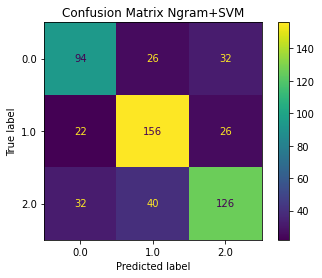

              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63       152
         1.0       0.70      0.76      0.73       204
         2.0       0.68      0.64      0.66       198

    accuracy                           0.68       554
   macro avg       0.67      0.67      0.67       554
weighted avg       0.68      0.68      0.68       554



In [ ]:
# plot the confusion matrix
plot_confusion_matrix(model, x_test, y_test, values_format='d')
plt.title("Confusion Matrix Ngram+SVM")
plt.show()

# print performance measurements (accuracy, precision, recall, f1-score)
print(classification_report(y_test,y_pred))

### LSTM (Long Short-Term Memory)

In [ ]:
# import keras library packages
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

# set vocabulary size
vocabSize = 3000

# create tokenizer object
tokenizer = Tokenizer(num_words = vocabSize, split=' ')
clean_tweets = df_new['Clean_text'].astype(str) # specifying the field datatype
label = df_new['label']
X_train,x_test,Y_train,y_test = train_test_split(clean_tweets,label,train_size=.80,random_state=420)

# apply tokenizer method on clean tweets to convert text into vector
tokenizer.fit_on_texts(clean_tweets.values)
X_train = tokenizer.texts_to_sequences(X_train.values)
X_train = pad_sequences(X_train, maxlen = 100, padding = 'pre', truncating = 'pre')

# le = LabelEncoder()
y_train = Y_train.values
y_train = y_train.reshape(-1, 1)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()
print(y_train)
# print("X_train\n")
# print(X_train)
# print(X_train.shape, y_train.shape)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
y_test.shape

(554,)

In [ ]:
# LSTM model
lstm_out = 128

model = Sequential()
model.add(Embedding(input_dim = vocabSize, output_dim=16, input_length = 100))  # add embedding layer
model.add(SpatialDropout1D(0.4)) # add dropout layer
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))  # add LSTM layer
model.add(Dense(3, activation = 'softmax'))  # add dense layer
print(model.summary())
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


# fit training model
batchSize = 64
print(X_train.shape, y_train.shape)
model.fit(X_train, y_train, epochs = 8, batch_size = batchSize, verbose = 1)

#model.save('./built_model/lstm_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')  # Load model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           48000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 122,627
Trainable params: 122,627
Non-trainable params: 0
_________________________________________________________________
None
(2216, 100) (2216, 3)
Epoch 1/8
35/35 [==============================] - 11s 241ms/step - loss: 1.0939 - accuracy: 0.3590
Epoch 2/8
35/35 [==============================] - 8s 240ms/step - loss: 1.0615 - accuracy: 0.4437
Epoch 3/8
35/35 [=====

In [ ]:
# predict stance for testing dataset

x_test = tokenizer.texts_to_sequences(x_test.values)
x_test = pad_sequences(x_test, maxlen = 100, padding = 'pre', truncating = 'pre')
y_pred=model.predict(x_test,batch_size=1,verbose = 2)

554/554 - 5s


In [ ]:
y_pred

array([[0.00280849, 0.95726424, 0.03992734],
       [0.01023094, 0.01784657, 0.9719225 ],
       [0.56910825, 0.01158717, 0.4193046 ],
       ...,
       [0.0165185 , 0.23083405, 0.75264746],
       [0.09824153, 0.18158975, 0.7201687 ],
       [0.04562829, 0.15460703, 0.7997647 ]], dtype=float32)

In [ ]:
# classification report

l=[]
for i in y_pred:
  l.append(np.argmax(i))
print(classification_report(y_test,l))

              precision    recall  f1-score   support

         0.0       0.74      0.73      0.73       151
         1.0       0.82      0.71      0.76       206
         2.0       0.66      0.76      0.71       197

    accuracy                           0.73       554
   macro avg       0.74      0.73      0.73       554
weighted avg       0.74      0.73      0.73       554



In [ ]:
cm=confusion_matrix(y_test,l)

In [ ]:
import seaborn as sn

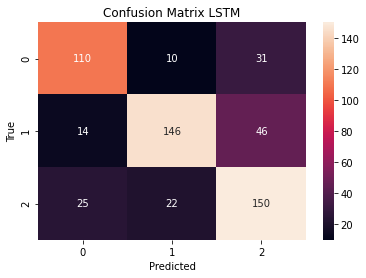

In [ ]:
df_cm = pd.DataFrame(cm, index = [i for i in "012"],
                  columns = [i for i in "012"])
sn.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix LSTM")
plt.show()

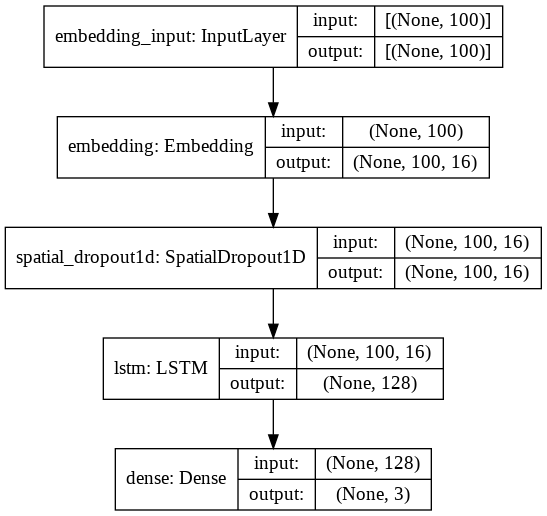

In [ ]:
# pictorial representation of LSTM model

from keras.utils import plot_model
plot_model(model, to_file='/content/model_plot4a.png', show_shapes=True, show_layer_names=True)